In [1]:
import copy
import json
import os
import sys
import time

In [2]:
from icecream import ic
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
import skimage.io as io

import torch
import torch.multiprocessing as mp
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models import densenet

from tqdm import tqdm

In [3]:
os.chdir('../')
sys.path.append('../dataset/')
import coco_data_prep
import coco_api_helper
import config_dataset

sys.path.append('../models/')
import densenet_inspired as di

loading annotations into memory...
Done (t=14.23s)
creating index...
index created!
loading annotations into memory...
Done (t=6.19s)
creating index...
index created!
loading annotations into memory...
Done (t=0.17s)
creating index...
index created!


In [4]:
%load_ext autoreload

### Global Variables

In [5]:
val_np_data_dir = '../data/numpy_imgs/val_subset/'
val_jpg_data_dir = '../data/raw/val/val2014/'
val_annot_filepath = '../data/raw/train/annotations/instances_val2014.json'

In [6]:
optim_params= dict(
    lr=0.001,
    betas=(0.9, 0.999),
    eps=1e-05,
    weight_decay=0.01,
    amsgrad=False,
)

### Load Checkpointed Model & Params

In [7]:
model = di.DensenetInspired()
optimizer = torch.optim.Adam(model.parameters(), **optim_params)

checkpoint = torch.load('./checkpoints/densenet_inspired_epoch_11.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()

/home/ec2-user/miniconda3/envs/cs7643-raml/lib/python3.8/site-packages/torch/nn/modules/lazy.py:175: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


DensenetInspired(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (mp1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU(inplace=True)
  (conv3): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (lin1): LazyLinear(in_features=0, out_features=1024, bias=True)
  (fc1): Linear(in_features=1024, out_features=80, bias=True)
)

In [8]:
def slice_model(original_model, from_layer=None, to_layer=None):
    return nn.Sequential(*list(original_model.children())[from_layer:to_layer])

model_conv_features = slice_model(model, to_layer=-1).to('cpu')
model_conv_features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (10): Flatten(start_dim=1, end_dim=-1)
  (11): LazyLinear(in_features=0, out_features=1024, bias=True)
)

### Make Embeddings for all Val Dataset

In [9]:
all_val_ds = coco_data_prep.COCODataset('val',
                                        val_np_data_dir, 
                                        val_annot_filepath,
                                        coco_data_prep.COCOAnnotationTransform(),
                                        device='cpu')

loading annotations into memory...
Done (t=6.29s)
creating index...
index created!


100%|███████████████████████████████████████████| 40504/40504 [00:25<00:00, 1586.30it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


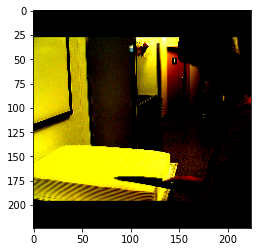

In [10]:
plt.imshow(all_val_ds[0][0].numpy().transpose(1, 2, 0))

In [11]:
all_val_ds.ids[0]

522418

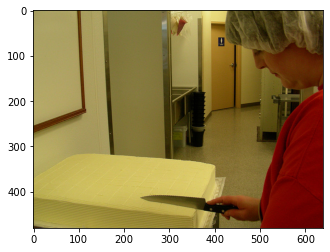

In [12]:
val = coco_api_helper.coco_objects['valid']
I = io.imread(val.loadImgs([all_val_ds.ids[0]])[0]['coco_url'])
plt.imshow(I)

In [14]:
# img_ids_in_order = [all_val_ds.ids[i] for i in range(len(all_val_ds))]

In [13]:
# densenet_index2cocoID = dict(zip(range(len(all_val_ds)), img_ids_in_order))
# with open ('../data/torch_embeddings/densenet_inspired/di_index2cocoIDs.json', 'w') as f:
#     json.dump(densenet_index2cocoID, f)

In [14]:
all_val_dl = coco_data_prep.get_dataloader(all_val_ds, 
                                         batch_size=1, 
                                         device='cpu',
                                         loader_params={'num_workers': 0,
                                                        'shuffle': False,
                                                        'collate_fn': lambda x : x})

In [15]:
len(all_val_dl)

21002

In [16]:
features_list = []

# Use GPUs to speed up the inference, this should take around 10 minutes
model_conv_features.to('cpu')

for i, batch in tqdm(enumerate(all_val_dl)):    
    image_batch, _ = [x[0] for x in batch], [x[1] for x in batch]
    image_batch = torch.stack(image_batch).to('cpu')

    with torch.no_grad():
        features_list.append(model_conv_features(image_batch))
        

21002it [07:43, 45.26it/s]


In [17]:
embeddings = torch.cat([b for b in features_list], dim=0)
embeddings.shape

torch.Size([21002, 1024])

#### Confirm Embeddings are Different for each Sample

In [21]:
embeddings[:10]

tensor([[-1.3452, -1.2807,  1.2842,  ...,  1.2994,  0.7744,  0.5642],
        [ 0.9867, -1.0505,  0.8009,  ...,  0.6428,  0.9849,  1.0166],
        [-0.5608, -1.0398,  1.0788,  ...,  0.5263,  0.8265,  0.2977],
        ...,
        [ 0.0758, -1.3002,  0.8423,  ...,  1.2297,  0.7613,  1.6185],
        [-0.9757, -0.9248,  1.4990,  ...,  0.9047,  0.7275,  0.3328],
        [ 0.4480, -1.1890,  0.6280,  ...,  0.7584,  1.3358,  1.1303]])

In [33]:
torch.save(embeddings, f'../data/torch_embeddings/densenet_inspired/di_embed_val_batch_{i}.pt')